In [1]:
import os

In [2]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [3]:
import torch
from torch import nn

In [4]:
# only for the subtract function which we're using for tensor functionality on torch.Size objects
import numpy as np

In [5]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [72]:
device_backend = torch.mps if device == 'mps' else torch.cuda
device_backend

<module 'torch.mps' from '/Users/zivlazarov/miniforge3/envs/pytorch/lib/python3.12/site-packages/torch/mps/__init__.py'>

### Q1

In [7]:
class CustomConv2d(nn.Module):
    def __init__(self, in_channels=1, out_channels=1,
                 kernel_size=(1, 1), stride=1, padding=0):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        if stride < 0:
            raise RuntimeError('stride cannot be a negative value!')
        if padding < 0:
            raise RuntimeError('padding cannot be a negative value!')

        self.stride = stride
        self.padding = padding

        self.kernel = nn.Parameter(
            torch.rand((out_channels, in_channels, *kernel_size))
        )
        # number of parameters for the bias tensor is the number of output channels
        self.bias = nn.Parameter(torch.rand((out_channels, )))
        # initializaing p,q kernel window sizes for simplicity
        self.p, self.q = kernel_size

    def forward(self, X):
        vertical_padding = torch.zeros((*(X.shape[:-1]), self.padding))
        # padding vertically and then padding horizontally. creating a list as it's mutable
        horizontal_padding_shape = list((*(X.shape[:-1]), X.shape[-1] + 2 * self.padding))
        # changing the relevant axis for padding to the padding size
        horizontal_padding_shape[2] = self.padding
        horizontal_padding_shape = tuple(horizontal_padding_shape)
        # creating the padding tensor
        horizontal_padding = torch.zeros(horizontal_padding_shape)
        # padding vertically, dim 3 is the columns of the pixels in each channel
        X = torch.cat((vertical_padding, torch.cat((X, vertical_padding), dim=3)), dim=3)
        # padding horizontally, dim 2 is the rows of the pixels in each channel
        X = torch.cat((horizontal_padding, torch.cat((X, horizontal_padding), dim=2)), dim=2)

        # expected X shape = (batch_size, n_channels, img_rows+2*padding, img_cols+2*padding)

        # getting the shape of the sub tensors
        view_shape = tuple(np.subtract(X.shape, self.kernel.shape) + 1) + self.kernel.shape
        # getting the strides for which we want to iterate in the batch
        strides = X.stride() + X.stride()
        # getting all sub tensors with the defined kernel shape
        sub_matrices_of_kernel_size = torch.as_strided(X, view_shape, strides)
        # getting all sub tensors of kernel size with the stride
        sub_matrices_of_kernel_size_strided = sub_matrices_of_kernel_size[:, :, ::self.stride, ::self.stride, ...]
        # getting the convolution
        convoluted_X = (sub_matrices_of_kernel_size_strided * self.kernel).sum(
            # first 4 dimensions of the are batch_size, number of channels, and image channels' shape
            dim=(tuple(range(4, 7+1)))
        )
        # incrementing each channel by the bias
        convoluted_X += self.bias

        return convoluted_X

In [8]:
import torchvision
from torch.utils.data import DataLoader

In [9]:
train_data_transformed = torchvision.datasets.FashionMNIST(root='./fashion_mnist',
                                                           train=True,
                                                           download=True,
                                                           transform=torchvision.transforms.PILToTensor())

train_dataloader = DataLoader(train_data_transformed, batch_size=64)

In [10]:
for batch_idx, (batch_X, batch_y) in enumerate(train_dataloader):
    imgs = batch_X
    break

In [11]:
imgs.shape

torch.Size([64, 1, 28, 28])

In [12]:
custom_conv_layer = CustomConv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), stride=2, padding=2)

In [13]:
custom_conv_layer(imgs).shape

torch.Size([64, 1, 15, 15])

In [14]:
import torchvision.transforms as T

In [15]:
conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), stride=2, padding=2)
conv_layer(imgs.to(torch.float32)).shape

torch.Size([64, 1, 15, 15])

### Q2

### Q3

#### Q3.a

In [16]:
cifar10_dataset = torchvision.datasets.CIFAR10(root='./cifar10',
                                              train=True,
                                              download=True,
                                              transform=T.PILToTensor())

Files already downloaded and verified


In [17]:
cifar10_dataloader = DataLoader(cifar10_dataset, batch_size=64)

In [18]:
for batch_idx, (batch_X, batch_y) in enumerate(cifar10_dataloader):
    imgs = batch_X
    break

In [19]:
imgs.shape

torch.Size([64, 3, 32, 32])

In [20]:
import matplotlib.pyplot as plt

In [21]:
img = next(iter(cifar10_dataloader))

In [22]:
img[0].shape, img[1]

(torch.Size([64, 3, 32, 32]),
 tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
         2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
         2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2]))

In [23]:
targets = np.array(cifar10_dataset.targets)

#### Q3.c

#### Plotting image from every class

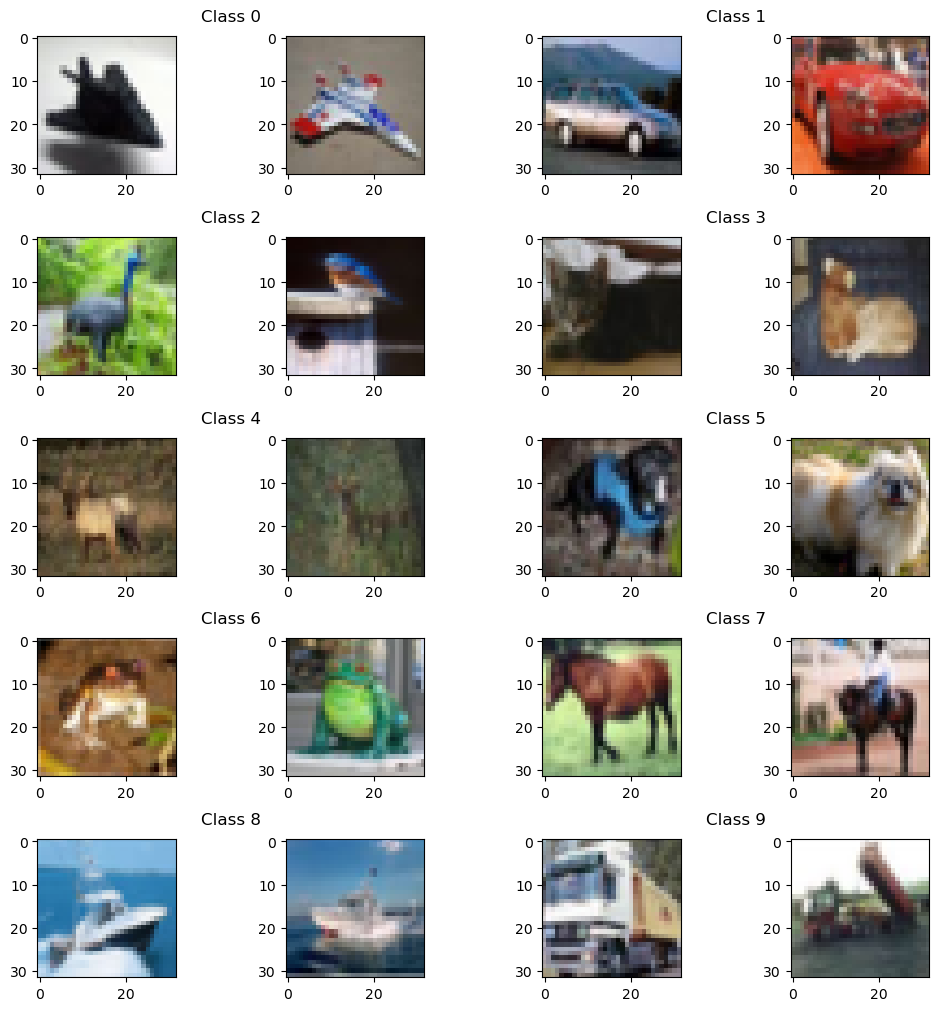

In [24]:
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
# creating the subfigures
subfigs = fig.subfigures(5, 2)

for class_idx, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Class {class_idx}')
    # getting the subfigure axes and plotting
    axes = subfig.subplots(1, 2)
    axes[0].imshow(cifar10_dataset.data[np.where(targets == class_idx)][0])
    axes[1].imshow(cifar10_dataset.data[np.where(targets == class_idx)][1])

#### Q3.d

#### Importing the ResNet18 pretrained model

In [25]:
import torchvision.models as models

In [26]:
resnet18 = models.resnet18(pretrained=True)

/Users/zivlazarov/miniforge3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zivlazarov/miniforge3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
for name, layer in resnet18.named_modules():
    print(f'{name}: {layer}')

: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


#### Q3.e

#### Changing the output layer to match the CIFAR10 dataset we imported

In [28]:
resnet18._modules['fc'] = nn.Linear(in_features=512, out_features=10, bias=True)
resnet18._modules['fc1'] = nn.LogSoftmax(dim=1)

#### Defining relevant transformation w.r.t the training data ResNet18 trained on

In [29]:
resnet_transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda t: t.to(dtype=torch.float, device=device)),
    # no need to standardize the values to match the training values range - the ToTensor transformation handles that for us
    # as the shape of the data if H x W x C. same thing can be said for the movedim functionality
    # T.Lambda(lambda t: t/255.0),
    # T.Lambda(lambda t: torch.movedim(t, 2, 0)),
#     T.Resize(256),
    T.Resize(224),
    # cropping to match the 224 dimensions of the training data
#     T.CenterCrop(224),
    T.Normalize(mean=torch.tensor([0.485, 0.456, 0.406]), std=torch.tensor([0.229, 0.224, 0.225])),
    # T.Lambda(lambda tensor: tensor.to(device))
])

resnet_target_transform = T.Compose([
    T.Lambda(lambda tensor: torch.tensor(tensor).to(device=device))
])

In [30]:
cifar10_dataset = torchvision.datasets.CIFAR10(root='./cifar10',
                                              train=True,
                                              download=False,
                                              transform=resnet_transform,
                                               target_transform=resnet_target_transform)

cifar10_dataloader = DataLoader(cifar10_dataset, batch_size=256, shuffle=True)
cifar10_dataloader_full = DataLoader(cifar10_dataset, batch_size=len(cifar10_dataset.data))

In [31]:
list(resnet18.modules())[-2:]

[Linear(in_features=512, out_features=10, bias=True), LogSoftmax(dim=1)]

#### Q3.f

#### Defining only the last 2 layers parameters' as the trained parameters

In [32]:
parameters = [param for name, param in resnet18.named_parameters() if name.startswith('fc')]

#### Turning off the autograd system for the non-trainable parameters in the model

In [33]:
for name, param in resnet18.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

#### Optimizer and Loss function

In [34]:
optimizer = torch.optim.Adam(parameters, lr=0.001, betas=(0.99, 0.99))

In [35]:
loss = nn.CrossEntropyLoss()

In [36]:
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Tensors for the training process

In [37]:
epochs = 5

train_loss, train_accuracy = torch.zeros(epochs).to(device), torch.zeros(epochs).to(device)

In [38]:
from tqdm import tqdm

In [39]:
@torch.no_grad
def evaluate_epoch(epoch_num, epoch_loss_values, epoch_num_correct_preds, dataset_size):
    epoch_accuracy = epoch_num_correct_preds / dataset_size
    epoch_loss = epoch_loss_values
    return epoch_loss, epoch_accuracy

In [40]:
@torch.no_grad
def evaluate_batch(epoch_num, batch_idx, model, loss_func, batch_X, batch_y):
    model.eval()

    batch_predictions = torch.argmax(model(batch_X), dim=1).to(dtype=torch.float, device=device)
    loss_value = loss_func(batch_predictions, batch_y.to(torch.float))
    num_correct_preds = (batch_predictions == batch_y).sum()
    return loss_value, num_correct_preds, batch_predictions

In [41]:
dataset_size = len(cifar10_dataset)
epoch_loss = 0
epoch_accuracy = 0

#### Training process

In [42]:
%timeit

for epoch in tqdm(range(epochs)):
    for batch_idx, (batch_X, batch_y) in enumerate(cifar10_dataloader):
        resnet18.train()
        
        optimizer.zero_grad()
        batch_output = resnet18(batch_X)
        batch_loss = loss(batch_output, batch_y)
        batch_loss.backward()
        optimizer.step()

        with torch.no_grad():
            resnet18.eval()
            
            batch_predictions = torch.argmax(batch_output, dim=1).to(dtype=torch.int, device=device)
            epoch_accuracy += (batch_predictions == batch_y.to(dtype=torch.int)).sum()
            epoch_loss += batch_loss

    train_loss[epoch], train_accuracy[epoch] = evaluate_epoch(epoch, epoch_loss, epoch_accuracy, dataset_size)

    epoch_loss = 0
    epoch_accuracy = 0

  0%|                                                               | 0/5 [00:00<?, ?it/s]/Users/zivlazarov/miniforge3/envs/pytorch/lib/python3.12/site-packages/torch/nn/functional.py:4055: UserWarning: The operator 'aten::_upsample_bilinear2d_aa.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1718580122180/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn._upsample_bilinear2d_aa(input, output_size, align_corners, scale_factors)
100%|██████████████████████████████████████████████████████| 5/5 [22:16<00:00, 267.31s/it]


#### Training metrics plots

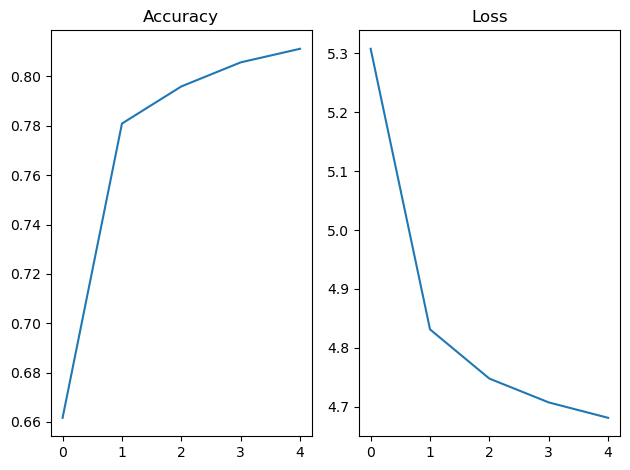

In [43]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(torch.arange(epochs), train_accuracy.to('cpu').detach().numpy(), label='Accuracy')
axes[0].set_title('Accuracy')
axes[1].plot(torch.arange(epochs), torch.log(train_loss).to('cpu').detach().numpy(), label='Loss')
axes[1].set_title('Loss')

fig.tight_layout()

In [44]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [73]:
if device != 'cpu':
    device_backend.empty_cache()

#### Creating the test data and evaluating the trained model

In [48]:
cifar10_test_dataset = torchvision.datasets.CIFAR10(root='./cifar10',
                                              train=False,
                                              download=True,
                                              transform=resnet_transform,
                                               target_transform=resnet_target_transform)

cifar10_test_dataloader = DataLoader(cifar10_test_dataset, batch_size=256)

Files already downloaded and verified


In [49]:
@torch.no_grad
def evaluate_test(model, loss_func, dataloader):
    model.eval()
    
    test_accuracy = 0
    test_loss = 0
    num_classes = len(np.unique(dataloader.dataset.targets))
    confusion_matrix = torch.zeros((num_classes, num_classes)).to(device)

    for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
        batch_loss, batch_correct_preds, batch_predictions = evaluate_batch(0, batch_idx, model, loss_func, batch_X, batch_y)
        batch_predictions = batch_predictions.to(dtype=torch.int, device=device)
        test_loss += batch_loss
        test_accuracy += batch_correct_preds
        
        for i in range(len(batch_X)):
            label_idx = batch_y[i] - 1
            preds_idx = batch_predictions[i] - 1
            confusion_matrix[label_idx, preds_idx] += 1
    
    test_accuracy = test_accuracy / len(dataloader.dataset.data)
    
    return torch.log(test_loss), test_accuracy, confusion_matrix

In [50]:
test_loss, test_accuracy, confusion_matrix = evaluate_test(resnet18, loss, cifar10_test_dataloader)

In [51]:
import seaborn as sns

#### Test metrics plot

Text(0.5, 1.0, 'Accuracy: 0.7997000217437744 | Loss (log): 12.608036041259766')

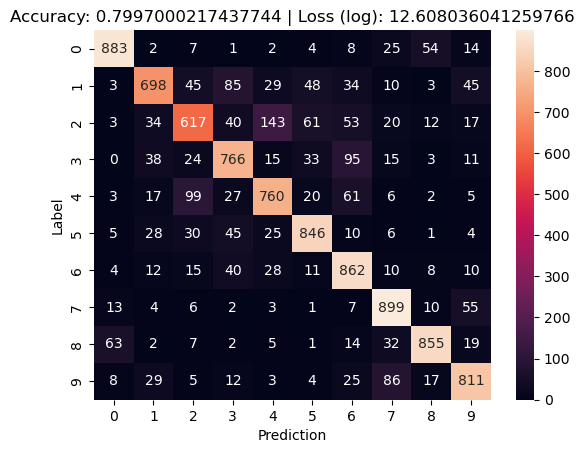

In [52]:
sns.heatmap(confusion_matrix.to('cpu').detach().numpy(), annot=True, fmt='.4g')
plt.ylabel('Label')
plt.xlabel('Prediction')
plt.title(f'Accuracy: {test_accuracy} | Loss (log): {test_loss}')

#### Q3.h

#### Getting the top 10 errors from the test evaluation stage

In [53]:
# a mask for nullifying the diagonal in the confusion matrix to get only errors
mask = torch.ones_like(confusion_matrix, dtype=torch.bool)
for i in range(len(mask)):
    mask[i, i] = 0

In [54]:
# topk returns the k largest elements/their indices in a given tensor
top10_errors_indices = torch.topk((confusion_matrix * mask).flatten(), 10).indices.reshape(-1, 1)

In [55]:
top10_errors_indices

tensor([[24],
        [42],
        [36],
        [97],
        [13],
        [80],
        [25],
        [46],
        [79],
        [ 8]], device='mps:0')

In [56]:
# transforming it to (row, col) indices instead of a number in [0, 100) range
top10_errors_indices_transform = T.Lambda(lambda value: (value // 10, value % 10))

In [57]:
row_indices, col_indices = top10_errors_indices_transform(top10_errors_indices)

In [58]:
for i in range(10):
    print(f'Predicted: {col_indices[i].item()} - Actual: {row_indices[i].item()} - {confusion_matrix[row_indices[i], col_indices[i]].item()}')

Predicted: 4 - Actual: 2 - 143.0
Predicted: 2 - Actual: 4 - 99.0
Predicted: 6 - Actual: 3 - 95.0
Predicted: 7 - Actual: 9 - 86.0
Predicted: 3 - Actual: 1 - 85.0
Predicted: 0 - Actual: 8 - 63.0
Predicted: 5 - Actual: 2 - 61.0
Predicted: 6 - Actual: 4 - 61.0
Predicted: 9 - Actual: 7 - 55.0
Predicted: 8 - Actual: 0 - 54.0


#### Q3.i

In [59]:
test_targets = np.array(cifar10_test_dataset.targets)

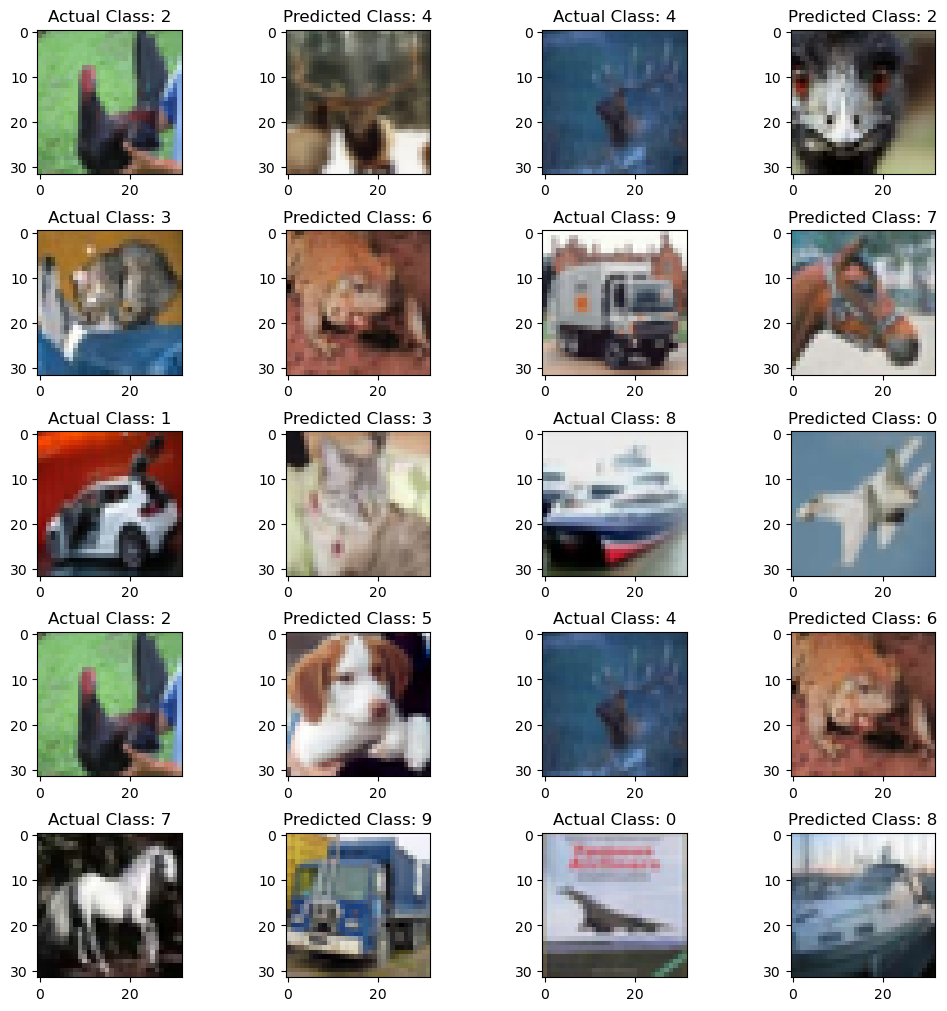

In [60]:
fig = plt.figure(constrained_layout=True, figsize=(10, 10))

# creating the subfigures
subfigs = fig.subfigures(5, 2)

for class_idx, subfig in enumerate(subfigs.flat):
    # getting the subfigure axes and plotting
    actual_idx = row_indices[class_idx].item()
    predicted_idx = col_indices[class_idx].item()
    axes = subfig.subplots(1, 2)
    axes[0].set_title(f'Actual Class: {actual_idx}')
    axes[0].imshow(cifar10_test_dataset.data[np.where(test_targets == actual_idx)][0].astype(np.uint8))
    axes[1].set_title(f'Predicted Class: {predicted_idx}')
    axes[1].imshow(cifar10_test_dataset.data[np.where(test_targets == predicted_idx)][1].astype(np.uint8))

#### Q3.j

#### Creating a new model

In [61]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Defining our custom model

In [62]:
class ResNetModel(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        # going with 32 output channels for the first layers
        out_channels = 32
        
        self.relu = nn.ReLU(inplace=True)
        # first block (non-residual)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

        # first residual block - receives an image with 32 input/output channels
        self.first_block = nn.Sequential(
            nn.ReLU(),
            # not adding bias as we have bias in the batchnorm layer
            nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            # same bias reason here
            nn.Conv2d(out_channels, out_channels, 3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # first skip, needs to match the input channels and to lower the width/height dimensions by 2
        self.downSample1 = nn.Conv2d(out_channels, out_channels, 1, stride=2, bias=False)

        # multiplying the output channels as we divided by 2 the number of pixels
        out_channels = out_channels * 2
        
        self.second_block = nn.Sequential(
            # setting input channels as previous block's output channels and multiplying the output channels for this block
            nn.Conv2d(out_channels // 2, out_channels, 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            # same bias reason here
            nn.Conv2d(out_channels, out_channels, 3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        # second skip
        self.downSample2 = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        out_channels = out_channels * 2
        
        self.third_block = nn.Sequential(            
            # setting input channels as previous block's output channels and multiplying the output channels for this block
            nn.Conv2d(out_channels // 2, out_channels, 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            # same bias reason here
            nn.Conv2d(out_channels, out_channels, 3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        # third skip
        self.downSample3 = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        # average pooling with the output layer of 10 classes
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(in_features=out_channels, out_features=10, bias=True)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, X):
        X0 = self.conv1(X)
        X0 = self.bn1(X0)
        X0 = self.relu(X0)
        X0 = self.maxpool(X0)
        # first block
        Y1_ = self.first_block(X0)
        Y1_1 = Y1_ + self.downSample1(X0)
        Y1 = self.relu(Y1_1)
        
        # second block
        Y2_ = self.second_block(Y1)
        Y2_2 = Y2_ + self.downSample2(Y1)
        Y2 = self.relu(Y2_2)
        
        # third block
        Y3_ = self.third_block(Y2)
        Y3_3 = Y3_ + self.downSample3(Y2)
        Y3 = self.relu(Y3_3)
        
        # pooling and linear
        Y = self.avgpool(Y3)
        # getting rid of empty dimensions
        Y = self.linear(Y.squeeze())
        Y = self.logsoftmax(Y)
        return Y

In [63]:
model = ResNetModel(in_channels=3)

In [64]:
# for name, param in model.named_parameters():
#     if not name.startswith('linear'):
#         param.requires_grad = False

In [65]:
# model_parameters = [param for name, param in model.named_parameters() if name.startswith('linear')]
model_parameters = model.parameters()

In [66]:
model_optimizer = torch.optim.Adam(model_parameters, lr=0.001, betas=(0.99, 0.99))
model_loss = nn.CrossEntropyLoss()

In [67]:
model.to(device)

ResNetModel(
  (relu): ReLU(inplace=True)
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (first_block): Sequential(
    (0): ReLU()
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (downSample1): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (second_block): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): 

In [68]:
epochs = 15
model_train_loss, model_train_accuracy = torch.zeros(epochs), torch.zeros(epochs)

epoch_loss = 0
epoch_accuracy = 0

#### Emptying cache from GPU a invoking the garbage collector

In [69]:
import gc

In [74]:
gc.collect()
if device != 'cpu':
    device_backend.empty_cache()

In [75]:
%timeit

for epoch in tqdm(range(epochs)):
    for batch_idx, (batch_X, batch_y) in enumerate(cifar10_dataloader):
        model.train()
        
        model_optimizer.zero_grad()
        batch_output = model(batch_X)
        batch_loss = model_loss(batch_output, batch_y)
        batch_loss.backward()
        model_optimizer.step()

        with torch.no_grad():
            model.eval()
            
            batch_predictions = torch.argmax(batch_output, dim=1).to(dtype=torch.int, device=device)
            epoch_accuracy += (batch_predictions == batch_y.to(dtype=torch.int)).sum()
            epoch_loss += batch_loss

    model_train_loss[epoch], model_train_accuracy[epoch] = evaluate_epoch(epoch, epoch_loss, epoch_accuracy, dataset_size)

    epoch_loss = 0
    epoch_accuracy = 0

100%|████████████████████████████████████████████████████| 15/15 [51:09<00:00, 204.64s/it]


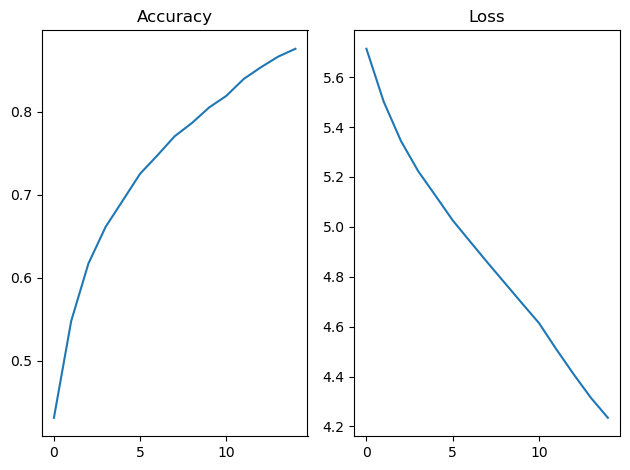

In [76]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(torch.arange(epochs), model_train_accuracy.to('cpu').detach().numpy(), label='Accuracy')
axes[0].set_title('Accuracy')
axes[1].plot(torch.arange(epochs), torch.log(model_train_loss).to('cpu').detach().numpy(), label='Loss')
axes[1].set_title('Loss')

fig.tight_layout()

In [77]:
test_loss, test_accuracy, confusion_matrix = evaluate_test(model, model_loss, cifar10_test_dataloader)

Text(0.5, 1.0, 'Accuracy: 0.7335000038146973 | Loss (log): 12.6160888671875')

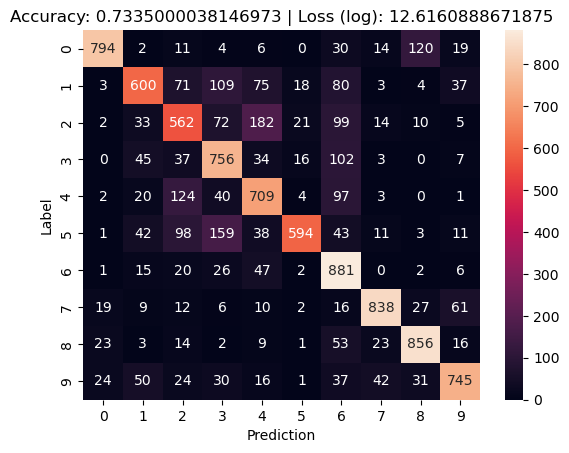

In [78]:
sns.heatmap(confusion_matrix.to('cpu').detach().numpy(), annot=True, fmt='.4g')
plt.ylabel('Label')
plt.xlabel('Prediction')
plt.title(f'Accuracy: {test_accuracy} | Loss (log): {test_loss}')

In [79]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

313514